## 1. Importing Libraries <a id='importing-libraries'></a>


In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import OneClassSVM

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup,BertModel

import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import uniform

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ai-vs-human-text/AI_Human.csv


## 2. Importing Data <a id='importing-data'></a>


In [ ]:
df = pd.read_csv("/kaggle/input/ai-vs-human-text/AI_Human.csv")

## 3. Data Exploration <a id='data-exploration'></a>


In [ ]:
df.head()

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487235 entries, 0 to 487234
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   text       487235 non-null  object 
 1   generated  487235 non-null  float64
dtypes: float64(1), object(1)
memory usage: 7.4+ MB


In [ ]:
df.describe()

,generated
count,487235.000000
mean,0.372383
std,0.483440
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


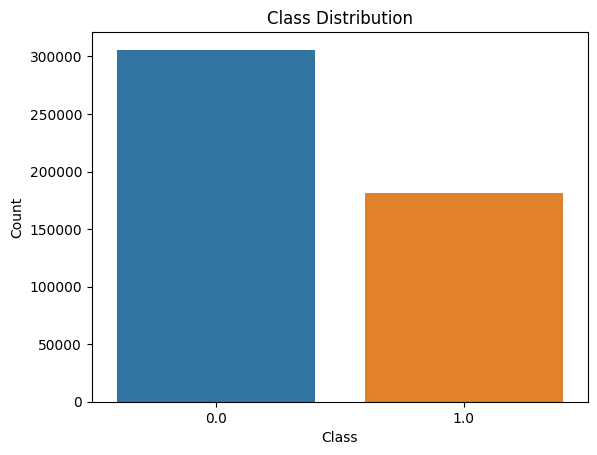

In [ ]:
sns.countplot(x=df['generated'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

## 4. Data Preprocessing <a id='data-preprocessing'></a>
In this section, we'll preprocess the text data by cleaning it, removing stopwords, and lemmatizing the words.

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [ ]:
english_stopwords = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [ ]:
def clean_text(text):
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', ' ', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in english_stopwords])
    return text

In [ ]:
df['clean_text'] = df['text'].apply(clean_text)

## 5. Word Clouds <a id='word-clouds'></a>


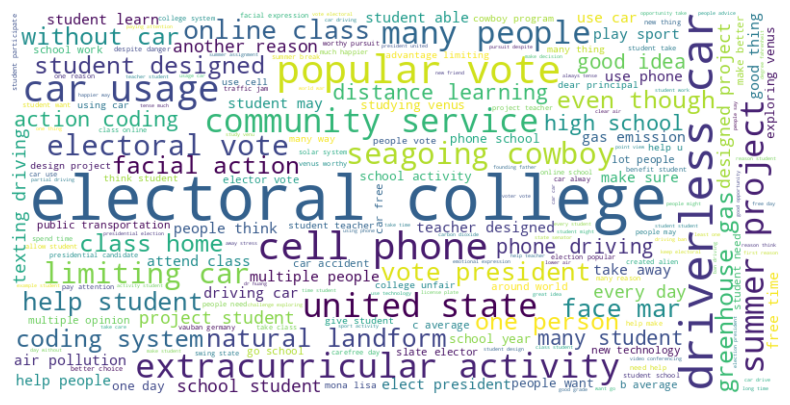

In [ ]:
human_data = df[df['generated'] == 0.0]
human_text = ' '.join(human_data['clean_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(human_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

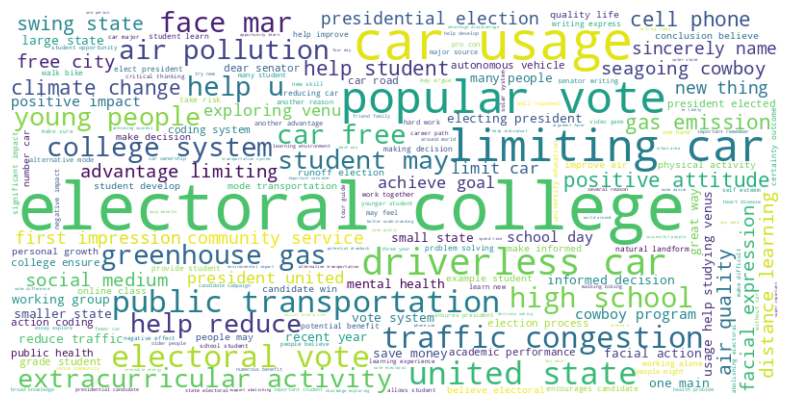

In [ ]:
# Generate word cloud for AI texts
ai_data = df[df['generated'] == 1.0]
ai_text = ' '.join(ai_data['clean_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ai_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## 6. Feature Engineering <a id='feature-engineering'></a>


In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['clean_text'])
y = df['generated']

## 7. Model Building and Evaluation <a id='model-building-and-evaluation'></a>


### Machine Learning Models <a id='machine-learning-models'></a>


In [ ]:
ml_df = df.sample(n=10000, random_state=42)

X_ml = vectorizer.fit_transform(ml_df['clean_text'])
y_ml = ml_df['generated']

X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X_ml, y_ml, test_size=0.2, random_state=42)

**Logistic Regression Model**

In [ ]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_ml, y_train_ml)
y_pred_log_reg = log_reg.predict(X_test_ml)
print("Logistic Regression Classification Report:\n", classification_report(y_test_ml, y_pred_log_reg))
print("Logistic Regression Accuracy:", accuracy_score(y_test_ml, y_pred_log_reg))

Logistic Regression Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.99      0.97      1232
         1.0       0.98      0.93      0.95       768

    accuracy                           0.96      2000
   macro avg       0.97      0.96      0.96      2000
weighted avg       0.97      0.96      0.96      2000

Logistic Regression Accuracy: 0.965


**Support Vector Machine (SVM) Model**

In [ ]:
svm = SVC(kernel='linear')
svm.fit(X_train_ml, y_train_ml)
y_pred_svm = svm.predict(X_test_ml)
print("SVM Classification Report:\n", classification_report(y_test_ml, y_pred_svm))
print("SVM Accuracy:", accuracy_score(y_test_ml, y_pred_svm))

SVM Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      1232
         1.0       0.98      0.95      0.97       768

    accuracy                           0.98      2000
   macro avg       0.98      0.97      0.98      2000
weighted avg       0.98      0.98      0.98      2000

SVM Accuracy: 0.9765


### Neural Network Approach <a id='neural-network-approach'></a>


**Data Sampling and Preprocessing**

In [ ]:
nn_df = df.sample(n=250000, random_state=42)

max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(nn_df['clean_text'])
sequences = tokenizer.texts_to_sequences(nn_df['clean_text'])
X_nn = pad_sequences(sequences, maxlen=max_len)

label_encoder = LabelEncoder()
y_nn = label_encoder.fit_transform(nn_df['generated'])

X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_nn, y_nn, test_size=0.2, random_state=42)

**Model Definition and Compilation**

In [ ]:
embedding_dim = 64
model_nn = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


**Model Training**

In [ ]:
history = model_nn.fit(X_train_nn, y_train_nn, epochs=5, batch_size=64, validation_data=(X_test_nn, y_test_nn))

Epoch 1/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 39s 11ms/step - accuracy: 0.9605 - loss: 0.1025 - val_accuracy: 0.9924 - val_loss: 0.0269
Epoch 2/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 33s 11ms/step - accuracy: 0.9938 - loss: 0.0210 - val_accuracy: 0.9944 - val_loss: 0.0211
Epoch 3/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 33s 11ms/step - accuracy: 0.9965 - loss: 0.0126 - val_accuracy: 0.9936 - val_loss: 0.0218
Epoch 4/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 33s 11ms/step - accuracy: 0.9979 - loss: 0.0079 - val_accuracy: 0.9958 - val_loss: 0.0160
Epoch 5/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 33s 11ms/step - accuracy: 0.9981 - loss: 0.0070 - val_accuracy: 0.9947 - val_loss: 0.0206


**Model Evaluation**

In [ ]:
nn_loss, nn_accuracy = model_nn.evaluate(X_test_nn, y_test_nn)
print(f"Neural Network Loss: {nn_loss}")
print(f"Neural Network Accuracy: {nn_accuracy}")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9945 - loss: 0.0207
Neural Network Loss: 0.020605148747563362
Neural Network Accuracy: 0.9946799874305725


### Preventing CUDA Out of Memory Errors


In [ ]:
!pip install GPUtil

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Preparing metadata (setup.py) ... - \ done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7394 sha256=80b22f730d358e707a63962135842e15585f31dac79c00285c3e0d270b380450
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil


In [ ]:
import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% | 92% |
|  1 |  0% |  1% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 69% |  1% |
|  1 |  0% |  0% |


### BERT-based Approach <a id='bert-based-approach'></a>


In [ ]:
bert_df = df.sample(n=300000, random_state=42)

Tokenization and Encoding

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

input_ids = []
attention_masks = []

for text in bert_df['clean_text']:
    encoded = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=100,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    input_ids.append(encoded['input_ids'])
    attention_masks.append(encoded['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(bert_df['generated'].values.astype(int))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Creating DataLoader

In [ ]:
# Create TensorDataset
dataset = TensorDataset(input_ids, attention_masks, labels)

# Split dataset into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoader for training and testing
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=32)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=32)

**Building and Training the BERT Model**



In [ ]:
model_bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

Define Optimizer and Scheduler

In [ ]:
optimizer = AdamW(model_bert.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_dataloader) * 4
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Train the Model

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_bert.to(device)

for epoch in range(4):
    print(f"Epoch {epoch + 1}/{4}")
    model_bert.train()

    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        batch_input_ids, batch_attention_masks, batch_labels = [item.to(device) for item in batch]

        model_bert.zero_grad()

        outputs = model_bert(input_ids=batch_input_ids, attention_mask=batch_attention_masks, labels=batch_labels)

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model_bert.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average training loss: {avg_train_loss:.2f}")

Epoch 1/4
Average training loss: 0.04
Epoch 2/4
Average training loss: 0.01
Epoch 3/4
Average training loss: 0.00
Epoch 4/4
Average training loss: 0.00


**Evaluating the BERT Model**

In [ ]:
model_bert.eval()
predictions, true_labels = [], []

for batch in test_dataloader:
    batch_input_ids, batch_attention_masks, batch_labels = [item.to(device) for item in batch]

    with torch.no_grad():
        outputs = model_bert(input_ids=batch_input_ids, attention_mask=batch_attention_masks)

    logits = outputs.logits
    predictions.extend(torch.argmax(logits, dim=1).tolist())
    true_labels.extend(batch_labels.tolist())

In [ ]:
print(classification_report(true_labels, predictions))
print(f"BERT Model Accuracy: {accuracy_score(true_labels, predictions)}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37619
           1       1.00      1.00      1.00     22381

    accuracy                           1.00     60000
   macro avg       1.00      1.00      1.00     60000
weighted avg       1.00      1.00      1.00     60000

BERT Model Accuracy: 0.9985666666666667


In [ ]:
output_dir = '/kaggle/working/bert_model/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model_bert.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"BERT model and tokenizer saved to {output_dir}")

BERT model and tokenizer saved to /kaggle/working/bert_model/


**Bert + OneClassSVM Model**

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model.to(device)

def get_bert_embeddings(texts, batch_size=16):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        encoded = tokenizer(
            batch,
            return_tensors='pt',
            padding=True,
            truncation=True,
            max_length=128
        ).to(device)
        with torch.no_grad():
            outputs = bert_model(**encoded)
        batch_embeds = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        embeddings.append(batch_embeds)
    return np.vstack(embeddings)

human_texts = df[df['generated'] == 0]['clean_text'].sample(2000, random_state=42).tolist()
ai_texts = df[df['generated'] == 1]['clean_text'].sample(2000, random_state=42).tolist()

X_train = get_bert_embeddings(human_texts)

X_test = get_bert_embeddings(human_texts[:500] + ai_texts[:500])
y_test = np.concatenate([np.ones(500), -np.ones(500)])

ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.1)
ocsvm.fit(X_train)

y_pred = ocsvm.predict(X_test)

y_pred_binary = np.where(y_pred == 1, 1, 0)
y_true_binary = np.where(y_test == 1, 1, 0)

In [ ]:
print("\n===== One-Class SVM Anomaly Detection Report =====")
print(classification_report(y_true_binary, y_pred_binary, target_names=['AI (Anomaly)', 'Human (Normal)']))
print(f"Accuracy: {accuracy_score(y_true_binary, y_pred_binary):.4f}")


In [ ]:
output_dir = '/kaggle/working/bert_model/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

ocsvm.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"BERT model and tokenizer saved to {output_dir}")